## Model
Neurips Paper about ConvLSTM: https://proceedings.neurips.cc/paper_files/paper/2015/file/07563a3fe3bbe7e3ba84431ad9d055af-Paper.pdf

In [1]:
import torch
import numpy as np
import chess
import chess.pgn
import chess.engine
import torch.nn as nn

# --- FEN to Tensor Encoding (12 channels: piece type x color) ---
piece_to_plane = {
    'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5,
    'p': 6, 'n': 7, 'b': 8, 'r': 9, 'q': 10, 'k': 11
}

def fen_to_tensor(fen):
    board = chess.Board(fen)
    tensor = np.zeros((12, 8, 8), dtype=np.float32)
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            row = 7 - (square // 8)  # flip vertically to match tensor layout
            col = square % 8
            tensor[piece_to_plane[piece.symbol()], row, col] = 1.0
    return torch.tensor(tensor, dtype=torch.float32)

# --- Simple Feedforward Model ---
class TwoMoveMateSolver(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()                       # 12x8x8 → 768
        self.fc1 = nn.Linear(768, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.output = nn.Linear(512, 4 * 64)              # 4 softmax heads over 64 squares

    def forward(self, x):
        x = self.flatten(x)           # [B, 768]
        x = F.relu(self.fc1(x))       # [B, 1024]
        x = F.relu(self.fc2(x))       # [B, 512]
        x = self.output(x)            # [B, 256]
        x = x.view(-1, 4, 64)         # [B, 4 moves, 64-square choices]
        return x


In [2]:
import torch
import torch.nn as nn

class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias=True):
        super().__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(
            in_channels=input_dim + hidden_dim,
            out_channels=4 * hidden_dim,
            kernel_size=kernel_size,
            padding=padding,
            bias=bias
        )
        self.hidden_dim = hidden_dim

    def forward(self, x, hidden):
        h_prev, c_prev = hidden
        combined = torch.cat([x, h_prev], dim=1)
        conv_output = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(conv_output, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)
        c_next = f * c_prev + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next

class ConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            in_dim = input_dim if i == 0 else hidden_dim
            self.layers.append(ConvLSTMCell(in_dim, hidden_dim, kernel_size))
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

    def forward(self, x):
        batch_size, seq_len, _, height, width = x.size()
        h = [torch.zeros(batch_size, self.hidden_dim, height, width, device=x.device) for _ in range(self.num_layers)]
        c = [torch.zeros(batch_size, self.hidden_dim, height, width, device=x.device) for _ in range(self.num_layers)]

        outputs = []
        for t in range(seq_len):
            input_t = x[:, t]
            for i, layer in enumerate(self.layers):
                h[i], c[i] = layer(input_t, (h[i], c[i]))
                input_t = h[i]
            outputs.append(h[-1])  # only final layer output

        return torch.stack(outputs, dim=1)  # shape: [B, T, C, H, W]

class ChessConvLSTMNet(nn.Module):
    def __init__(self, input_channels=12, hidden_dim=64, num_layers=2, kernel_size=3, output_dim=64, output_seq_len=4):
        super().__init__()
        self.output_seq_len = output_seq_len
        self.convlstm = ConvLSTM(input_channels, hidden_dim, kernel_size, num_layers)
        self.head = nn.Sequential(
            nn.Flatten(start_dim=2),  # from [B, T, C, 8, 8] to [B, T, C*8*8]
            nn.Linear(hidden_dim * 8 * 8, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim)
        )

    def forward(self, x):
        # x: [B, T, C, 8, 8]
        lstm_outputs = self.convlstm(x)  # [B, T, C, 8, 8]
        logits = self.head(lstm_outputs)  # [B, T, output_dim]
        return logits


## Dataset

In [3]:
import torch
import pandas as pd
import chess
from torch.utils.data import Dataset

class TwoMoveMateDataset(Dataset):
    def __init__(self, csv_path):
        self.df = pd.read_csv(csv_path)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        fen = row['fen']
        move1 = chess.Move.from_uci(row['move1'])
        move2 = chess.Move.from_uci(row['move2'])

        # Encode board state
        input_tensor = fen_to_tensor(fen)

        # Encode moves as 4 target indices: from1, to1, from2, to2
        label = torch.tensor([
            move1.from_square,
            move1.to_square,
            move2.from_square,
            move2.to_square
        ], dtype=torch.long)

        return input_tensor, label

In [4]:
class TwoMoveMateDatasetLSTM(Dataset):
    def __init__(self, csv_path):
        self.df = pd.read_csv(csv_path)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        fen = row['fen']
        move1 = chess.Move.from_uci(row['move1'])
        move2 = chess.Move.from_uci(row['move2'])

        # You need two board states as input:
        # 1. Original position
        # 2. After move1 is played

        board1 = chess.Board(fen)
        input1 = fen_to_tensor(board1.fen())

        board1.push(move1)
        input2 = fen_to_tensor(board1.fen())

        # Stack into a sequence: [2, C, 8, 8]
        input_seq = torch.stack([input1, input2], dim=0)  # [2, C, 8, 8]

        # Encode labels: [2] for two destination squares (or [2, 64] if you use from-to)
        label = torch.tensor([
            move1.to_square,
            move2.to_square
        ], dtype=torch.long)

        return input_seq, label


## Train

In [5]:
# --- Hyperparameters
batch_size = 64
epochs = 10
lr = 1e-3

In [6]:
# --- Data
# from torch.utils.data import DataLoader

# # dataset = TwoMoveMateDataset('mate_in_2_simple.csv')
# dataset = TwoMoveMateDatasetLSTM('mate_in_2_simple.csv')
# loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

from torch.utils.data import random_split, DataLoader

# Load full dataset
dataset = TwoMoveMateDatasetLSTM("mate_in_2_simple.csv")

# 80-20 split
total_size = len(dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [12]:
# --- Model and training setup
import glob
import os
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = TwoMoveMateSolver().to(device)
model = ChessConvLSTMNet().to(device)

# checkpoint_files = glob.glob("convlstm_model_epoch*.pt")
# if checkpoint_files:
#     latest_checkpoint = max(checkpoint_files, key=os.path.getmtime)
    
#     model.load_state_dict(torch.load(latest_checkpoint, map_location=device))
#     print(f"Loaded model from {latest_checkpoint}")
# else:
#     print("No model checkpoint found, starting from scratch.")


optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()

In [13]:
from tqdm import tqdm
start_epoch = 0
total_epochs = 10
train_acc_list = []
test_acc_list = []
for epoch in range(start_epoch, total_epochs):
    # ---- Training ----
    model.train()
    total_loss = 0
    correct_moves = 0
    total_moves = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1} [Train]"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = 0
        for i in range(2):
            loss += criterion(outputs[:, i, :], labels[:, i])
            preds = outputs[:, i, :].argmax(dim=1)
            correct_moves += (preds == labels[:, i]).sum().item()
            total_moves += labels.size(0)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    train_loss = total_loss / len(train_loader)
    train_acc = correct_moves / total_moves

    # ---- Evaluation ----
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc=f"Epoch {epoch + 1} [Test]"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)

            for i in range(2):
                test_loss += criterion(outputs[:, i, :], labels[:, i]).item()
                preds = outputs[:, i, :].argmax(dim=1)
                test_correct += (preds == labels[:, i]).sum().item()
                test_total += labels.size(0)

    test_loss /= len(test_loader)
    test_acc = test_correct / test_total

    print(f"Epoch {epoch + 1} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f}, Acc: {test_acc:.4f}")

    torch.save(model.state_dict(), f"convlstm_model_epoch{epoch}.pt")


    # After each epoch
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)



Epoch 1 [Test]: 100%|██████████████████████████████████████████████████████████████| 1819/1819 [01:24<00:00, 21.64it/s]


Epoch 1 | Train Loss: 3.3528, Acc: 0.5462 | Test Loss: 2.4946, Acc: 0.6532


Epoch 2 [Test]: 100%|██████████████████████████████████████████████████████████████| 1819/1819 [01:23<00:00, 21.90it/s]


Epoch 2 | Train Loss: 2.1560, Acc: 0.6965 | Test Loss: 2.2422, Acc: 0.6867


Epoch 3 [Test]: 100%|██████████████████████████████████████████████████████████████| 1819/1819 [01:23<00:00, 21.84it/s]


Epoch 3 | Train Loss: 1.7118, Acc: 0.7529 | Test Loss: 2.2201, Acc: 0.6956


Epoch 4 [Test]: 100%|██████████████████████████████████████████████████████████████| 1819/1819 [01:23<00:00, 21.81it/s]


Epoch 4 | Train Loss: 1.3515, Acc: 0.8001 | Test Loss: 2.3663, Acc: 0.6949


Epoch 5 [Test]: 100%|██████████████████████████████████████████████████████████████| 1819/1819 [01:22<00:00, 22.01it/s]


Epoch 5 | Train Loss: 1.0402, Acc: 0.8432 | Test Loss: 2.6082, Acc: 0.6889


Epoch 6 [Test]: 100%|██████████████████████████████████████████████████████████████| 1819/1819 [01:21<00:00, 22.25it/s]


Epoch 6 | Train Loss: 0.7801, Acc: 0.8790 | Test Loss: 2.9824, Acc: 0.6838


Epoch 7 [Test]: 100%|██████████████████████████████████████████████████████████████| 1819/1819 [01:28<00:00, 20.61it/s]


Epoch 7 | Train Loss: 0.5700, Acc: 0.9096 | Test Loss: 3.4158, Acc: 0.6768


Epoch 8 [Test]: 100%|██████████████████████████████████████████████████████████████| 1819/1819 [01:27<00:00, 20.77it/s]


Epoch 8 | Train Loss: 0.4245, Acc: 0.9311 | Test Loss: 3.9058, Acc: 0.6731


Epoch 9 [Test]: 100%|██████████████████████████████████████████████████████████████| 1819/1819 [01:24<00:00, 21.44it/s]


Epoch 9 | Train Loss: 0.3317, Acc: 0.9451 | Test Loss: 4.3278, Acc: 0.6725


Epoch 10 [Test]: 100%|█████████████████████████████████████████████████████████████| 1819/1819 [01:20<00:00, 22.57it/s]

Epoch 10 | Train Loss: 0.2784, Acc: 0.9540 | Test Loss: 4.5506, Acc: 0.6712


## Visualizing Performance

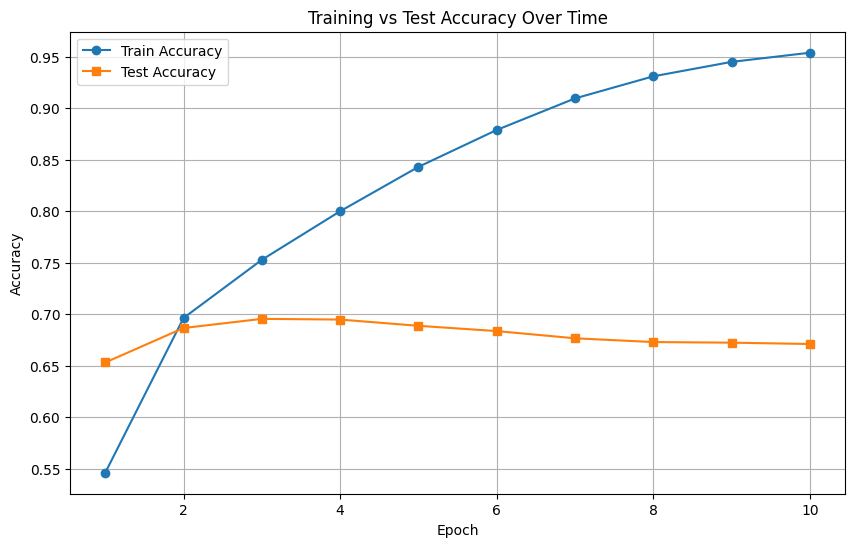

In [14]:
import matplotlib.pyplot as plt

epochs = list(range(start_epoch + 1, start_epoch + 1 + len(train_acc_list)))
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc_list, label="Train Accuracy", marker='o')
plt.plot(epochs, test_acc_list, label="Test Accuracy", marker='s')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Test Accuracy Over Time")
plt.legend()
plt.grid(True)
plt.show()

In [21]:
## Old code for the naive approach
# for epoch in range(epochs):
#     model.train()
#     total_loss = 0
#     correct_moves = 0
#     total_moves = 0

#     for inputs, labels in loader:
#         inputs = inputs.to(device)
#         labels = labels.to(device)

#         optimizer.zero_grad()
#         output = model(inputs)  # shape: [B, 4, 64]

#         loss = 0
#         for i in range(4):
#             loss += criterion(output[:, i, :], labels[:, i])
#             preds = output[:, i, :].argmax(dim=1)
#             correct_moves += (preds == labels[:, i]).sum().item()
#             total_moves += labels.size(0)

#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()

#     avg_loss = total_loss / len(loader)
#     accuracy = correct_moves / (total_moves)
#     print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | Accuracy: {accuracy:.4f}")
#     torch.save(model.state_dict(), f"convlstm_model_{epoch}.pt")
#     print(f"Model saved as 'convlstm_model_{epoch}.pt'")

## Convert to just Mate in 2 csv

In [27]:
# Load the Lichess puzzle CSV (decompressed)
# df = pd.read_csv("lichess_db_puzzle.csv", low_memory=False)

# # Step 1: Filter for mate-in-2 puzzles
# df = df[df["Themes"].str.contains("mateIn2", na=False)]

# # Step 2: Keep only puzzles where White moves first
# df = df[df["FEN"].str.split().str[1] == "w"]

# # Step 3: Get player's first and second moves (0 and 2)
# df["move_list"] = df["Moves"].str.split()
# df = df[df["move_list"].str.len() >= 3]
# df["move1"] = df["move_list"].apply(lambda m: m[0])
# df["move2"] = df["move_list"].apply(lambda m: m[2])

# # Step 4: Save just the FEN and two moves
# df = df[["FEN", "move1", "move2"]].rename(columns={"FEN": "fen"})
# df.to_csv("mate_in_2_simple.csv", index=False)